# Training with FastAI

In this notebook, we will train a model using the FastAI library. We will go through the following steps:

1. Finding a good learning rate.
2. Training the model.
3. Unfreezing the model and training again.
4. Saving the model.


## Setting up the data

Our training images are stored in the `dataset/train` directory, and the labels are part of the path. 
For example: `dataset/train/lola/0001.jpg` is an image of class `lola`.

We will load the images using the DataBlock API and create a DataLoaders object, and apply data transformations like data augmentation and resizing.


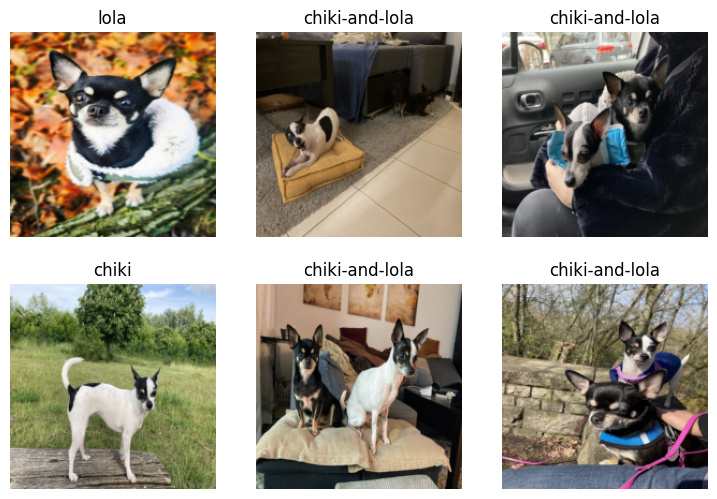

In [32]:
# Set the environment variable to enable CPU fallback for PyTorch operations not currently supported by Apple's Metal Performance Shaders (MPS)
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from fastai.vision.all import *

# Specify the path to the training dataset
path = Path('../dataset/train')

# Create a DataBlock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # We're working with images and categories
    get_items=get_image_files,  # How to get the images
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # How to split into train/valid
    get_y=parent_label,  # How to label images
    item_tfms=[Resize(192, method='squish')],  # Item-level transformations
    # batch_tfms=aug_transforms(size=128, min_scale=0.75)  # Batch-level transformations (won't work on macOS)
).dataloaders(path, bs=32)  # Create DataLoaders

# Show a batch of images
dls.show_batch(max_n=6)   

## Finding a Good Learning Rate

The learning rate is one of the most important hyperparameters for training a deep learning model. FastAI provides a method `lr_find` to help find a good learning rate.

The learning rate is plotted against the loss, and we will choose a learning rate where the loss is still decreasing.

SuggestedLRs(minimum=0.006918309628963471, steep=6.309573450380412e-07, valley=0.0006918309954926372, slide=0.0006918309954926372)

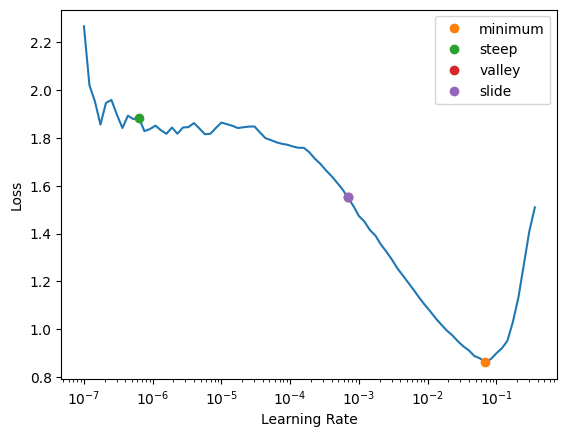

In [33]:
# Create a Learner
learn = vision_learner(dls, resnet18, metrics=error_rate)
# Find the optimal learning rate
suggestions = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
suggestions

## Training the model

We will train the model using the `fit_one_cycle` method. This method uses the 1cycle policy for training the model. The 1cycle policy is a learning rate schedule that varies the learning rate during training. It starts with a low learning rate, increases it to a maximum value, and then decreases it again. This helps to train the model faster and with better performance.


In [34]:
# Use the suggested minimum learning rate
lr_min = suggestions.minimum

# Train the model
learn.fit_one_cycle(10, lr_min, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3))

No improvement since epoch 2: early stopping


## Inspecting the results

 By calling the `show_results()` function, we can visually the model's predictions against the actual values from the validation set. This helps us understand how well our model has learned from the training process and its ability to make accurate predictions.

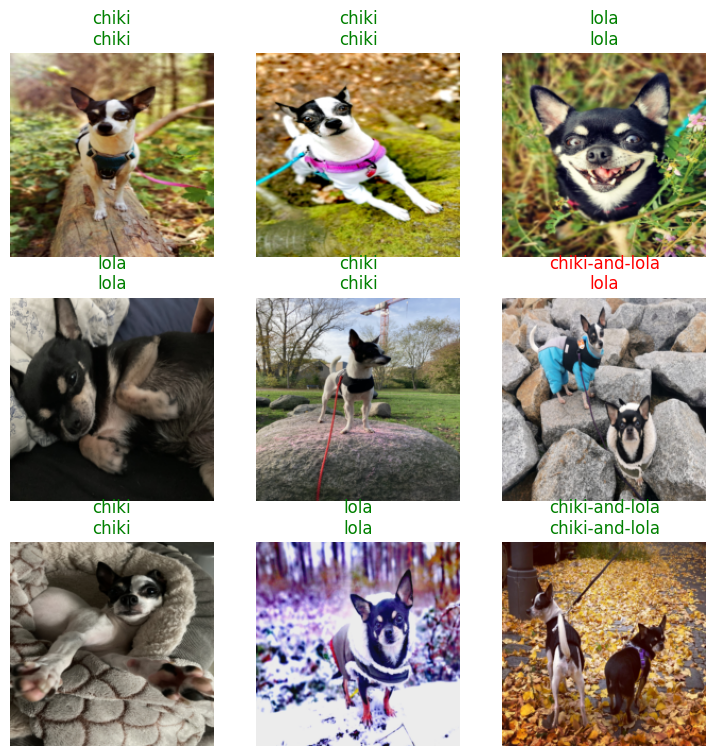

In [35]:
learn.show_results()

We can now use the  `plot_confusion_matrix` to visualize the performance. The function outputs a matrix that illustrates the correct and incorrect predictions made by the classifier, broken down by each class. This allows us to see not just how many predictions were incorrect, but also what types of errors the classifier is making. For example, a high value in the off-diagonal of the confusion matrix indicates many misclassifications between two classes.

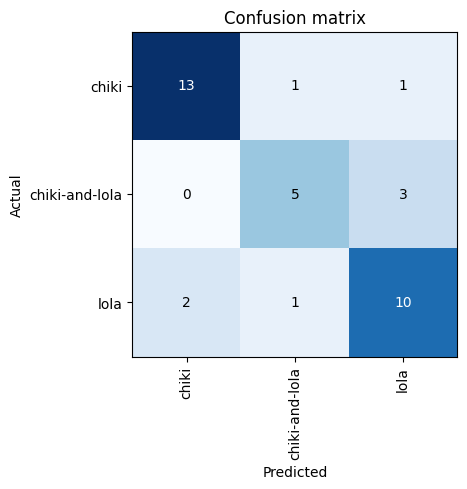

In [36]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Calculate the classification report
from sklearn.metrics import classification_report

# Get the classification report
report = classification_report(actual_labels, pred_labels, target_names=label_names)

# Print the classification report
print(report)

In machine learning, the term "top losses" refers to the instances where the model's predictions were most incorrect. These are the instances where the actual output and the model's predicted output have the maximum difference.

Let's call the `plot_top_losses` function to visualize these instances. This function displays the images with the highest loss in your validation set. It's a useful tool for understanding where the model is making its biggest mistakes.

It seems that the model is having a hard time predicting the class `chiki-and-lola`. We can use the `interp.plot_top_losses` method to see the images with the highest loss for this class.


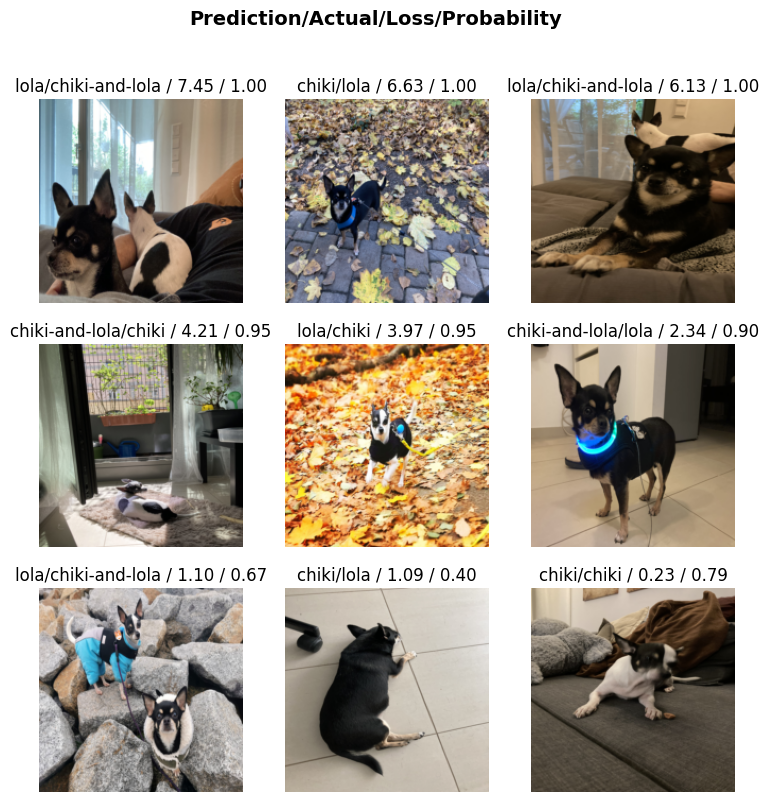

In [121]:
interp.plot_top_losses(9, nrows=3)

# Evaluate the model with a test dataset

We will use the test dataset to evaluate the model's performance. We will load the test images using the DataBlock API and create a DataLoaders object. We will then use the `validate` method to evaluate the model on the test dataset.

In [110]:
# Load the test dataset
test_path = Path('../dataset/test')
test_dl = dls.test_dl(get_image_files(test_path), with_labels=True)

# Evaluate the model on the test dataset
predictions, targets, decoded_predictions = learn.get_preds(dl=test_dl, with_decoded=True)

# Convert predictions to labels
test_pred_labels = np.argmax(predictions, axis=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


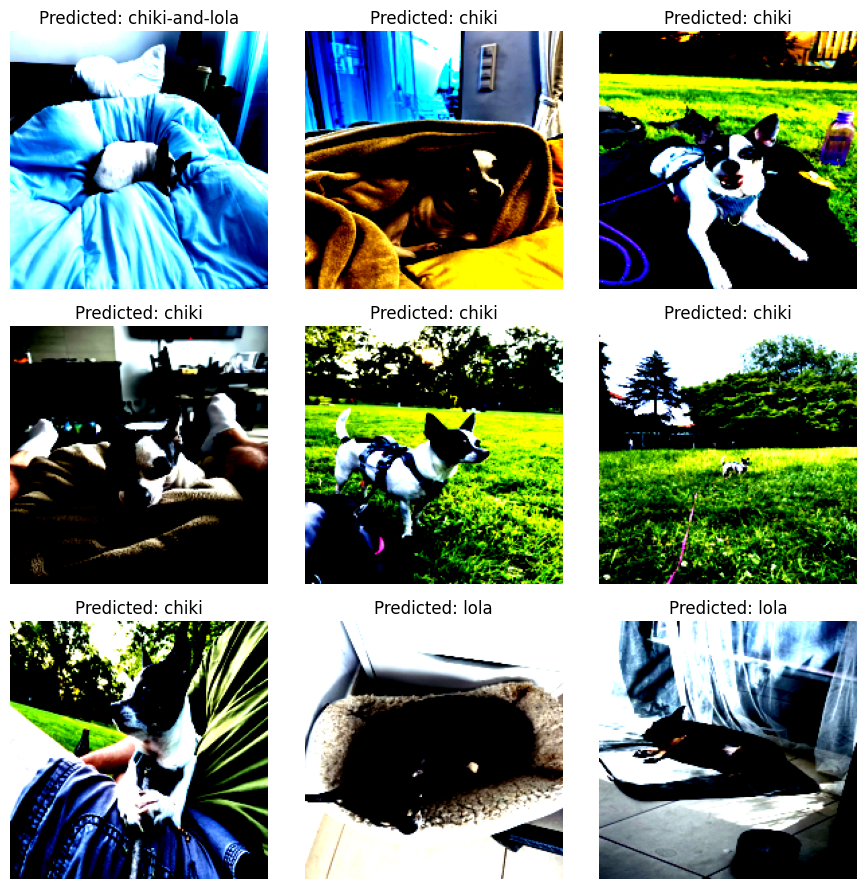

In [79]:
import matplotlib.pyplot as plt

# Get a batch of data
batch = test_dl.one_batch()
imgs = batch[0]

# Plot images with predicted labels
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axs.flatten()):
    img = imgs[i].permute(1, 2, 0)
    ax.imshow(img.cpu().numpy())
    ax.set_title(f'Predicted: {dls.vocab[decoded_predictions[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's also see a confusion matrix to visualize the performance of our model on the test dataset by comparing the actual labels against the predicted labels. This way, we can easily identify where our model is making correct predictions and where it's making mistakes.

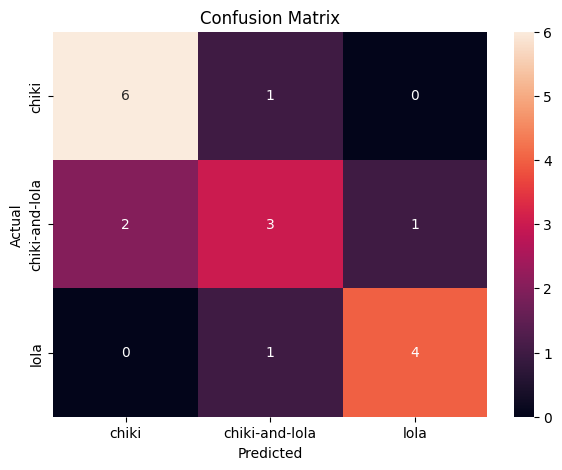

In [114]:
# Analyze the performance of the model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the actual_labels
actual_labels = [y for _, y in test_dl]
# Flatten the list of actual_labels to match the shape of the predicted labels
actual_labels = actual_labels[0].tolist()

# Get the predicted class indices
pred_labels = predictions.argmax(dim=-1)

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, pred_labels)

label_names = dls.vocab

# Create a DataFrame from the confusion matrix for better visualization
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(7,5))

# Use seaborn to plot heatmap
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()


## Unfreezing the model and training again

TODO

## Saving the model

In [132]:
from datetime import datetime

model_path = Path('models') / f"fastai_resnet18_pet_classifier_{datetime.now():%Y%m%d}.pkl"

# Save the model
learn.export(model_path)


## Loading and using the model

Class Probability
0           chiki      99.99%
1  chiki-and-lola       0.01%
2            lola       0.00%

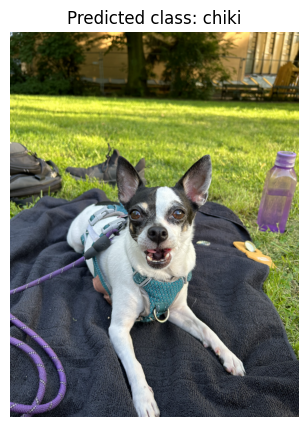

In [133]:
# Load the model
learn = load_learner(model_path)


# Make a prediction
img = PILImage.create('../data/test/chiki.jpg')
pred_class, pred_idx, probs = learn.predict(img)

img.show(title=f"Predicted class: {pred_class}")

class_names = learn.dls.vocab
preds = {class_names[i]: probs[i].item() for i in range(len(class_names))}

# Create a DataFrame and display it
df = pd.DataFrame(list(preds.items()), columns=['Class', 'Probability'])
df['Probability'] = df['Probability'].apply(lambda x: f"{x*100:.2f}%")
display(df)
